# Trace Veloce Spectra

Steps:
1. measure bias overscan + remove gaps
2. detect flux through thresholding to get initial trace for each order
   - flux for one row -> get threshold (median_filtr)
   - result: pixels belonging to orders, this is done on flats  
3. average in cross-dispersion (x) direction, and fit the polynomial 
4. work out summing range (manual)

##### Imports and functions

In [ ]:
### prepare master flats in Master folder and push to repo

In [1]:
import gc
import pickle
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import median_filter
# from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import mode

# from csaps import csaps

In [2]:
from simple_veloce_reduction import veloce_reduction_tools, veloce_config, veloce_logs, veloce_wavecalib

In [3]:
# def add_alpha_channel(mask):
#     red_channel = 255*mask
#     green_channel = np.zeros_like(mask)
#     blue_channel = np.zeros_like(mask)
#     alpha_channel = 255*mask
#     return np.stack((red_channel, green_channel, blue_channel, alpha_channel), axis=-1)

def merge_masks_with_alpha(masks):
    # Assuming all masks have the same shape
    height, width = masks[0].shape
    
    # Initialize the red, green, blue, and alpha channels
    red_channel = np.zeros((height, width), dtype=np.uint8)
    green_channel = np.zeros((height, width), dtype=np.uint8)
    blue_channel = np.zeros((height, width), dtype=np.uint8)
    alpha_channel = np.zeros((height, width), dtype=np.uint8)
    
    # Combine all masks into the red and alpha channels
    for mask in masks:
        red_channel = 255*np.maximum(red_channel, mask)
        alpha_channel = 255*np.maximum(alpha_channel, mask)
    
    # Merge channels into a single image with an alpha channel
    merged_image = np.stack((red_channel, green_channel, blue_channel, alpha_channel), axis=-1)
    
    return merged_image

In [5]:
# def fit_ccf_peak(pix_shift, ccf, fitting_limit=10):
#     center_peak_idx = np.argmax(ccf)
#     fitting_slice = slice(max(0, int(center_peak_idx-fitting_limit+0.5)), min(len(ccf), int(center_peak_idx+fitting_limit+1.5)))
#     _pix_shift = pix_shift[fitting_slice]
#     _ccf = ccf[fitting_slice]

#     # fit a generalised gaussian to the peak
#     peak_arg = np.argmax(_ccf)
#     peak = _ccf[peak_arg]
#     peak_position = _pix_shift[peak_arg]
#     sigma = 0.8
#     beta = 2.0
#     baseline = np.min(_ccf)
#     try:
#         popt, _ = curve_fit(veloce_wavecalib.general_gaussian, _pix_shift, _ccf,
#                         p0=[peak, peak_position, sigma, beta, baseline],
#                         bounds=([0, np.min(_pix_shift), 1e-3, 1e-3, 0], [2*peak, np.max(_pix_shift), 10, 10, peak]),)
        
#         plt.figure()
#         plt.plot(_pix_shift, _ccf, 'ko', label='CCF data')
#         plt.plot(_pix_shift, veloce_wavecalib.general_gaussian(_pix_shift, *popt), 'r-', label='Fitted Gaussian')
#         plt.xlabel('Pixel Shift')
#         plt.ylabel('CCF')
#         plt.legend()
#         plt.title(f'CCF Peak Fitting, shift={popt[1]:.3f} pix')
#         plt.show()
        
#         return popt[1], popt, fitting_limit #fitting_slice
#     except Exception as e:
#         print(f"[Warning] LC peak fitting failed: {e}")
#         plt.figure()
#         plt.plot(_pix_shift, _ccf, 'ko', label='CCF data')
#         plt.xlabel('Pixel Shift')
#         plt.ylabel('CCF')
#         plt.title('CCF Peak Fitting (failed)')
#         plt.legend()
#         plt.show()
#         return np.nan, [np.nan], np.nan 

In [6]:
# def determine_trace_shift(image, reference_image=None, row=None):
#     if reference_image is None:
#         # TODO: use master flat from CSV
#         reference_image = image.copy()
#     pix_shift = np.arange(-1*image.shape[1]+1, image.shape[1], 1)
#     _shifts = []
#     if row is None:
#         ccf = np.zeros((image.shape[0], image.shape[1]*2-1))
#         for row in range(300, image.shape[0]-300, 50):  # avoid edges
#             if np.std(image[row,:]) > 500:  # only do cross-correlation for rows with signal
#                 ccf[row] = np.correlate(image[row,:], reference_image[row,:], mode='full')
#                 _shifts.append(pix_shift[np.argmax(ccf[row])])
#                 # _shifts.append(fit_ccf_peak(pix_shift, ccf[row], fitting_limit=7)[0])
#         # shift = mode(_shifts)[0]
#         shift = np.nanmedian(_shifts)
#     else:
#         if np.std(image[row,:]) > 500:
#             ccf = np.correlate(image[row,:], reference_image[row,:], mode='full')
#             # shift = fit_ccf_peak(pix_shift, ccf, fitting_limit=7)[0]
#             shift = pix_shift[np.argmax(ccf)]
#         else:
#             print(f'Row {row} has no signal')
#             return np.nan, [np.nan], [np.nan]
    
#     return shift, pix_shift, ccf

In [7]:
# def determine_vertical_trace_shift(image, reference_image=None, column=None, x_shift=0):
    # if reference_image is None:
    #     # TODO: use master flat from CSV
    #     reference_image = image.copy()
    # if x_shift == 0:
    #     pass
    # elif x_shift > 0:
    #     _image = image[:, x_shift:].copy()
    #     _reference_image = reference_image[:, :-x_shift].copy()
    # elif x_shift < 0:
    #     image = image[:, :x_shift]
    #     reference_image = reference_image[:, -x_shift:]
    # pix_shift = np.arange(-1*image.shape[0]+1, image.shape[0], 1)
    # _shifts = []
    # if column is None:
    #     ccf = np.zeros((image.shape[1], image.shape[0]*2-1))
    #     for column in range(300, image.shape[0]-300, 50):  # avoid edges
    #         if np.std(image[:,column]) > 500:  # only do cross-correlation for rows with signal
    #             ccf[column] = np.correlate(image[:,column], reference_image[:,column], mode='full')
    #             _shifts.append(pix_shift[np.argmax(ccf[column])])
    #             # _shifts.append(fit_ccf_peak(pix_shift, ccf[row], fitting_limit=7)[0])
    #     shift = mode(_shifts)[0]
    #     # shift = np.nanmedian(_shifts)
    # else:
    #     if np.std(image[:,column]) > 500:
    #         ccf = np.correlate(image[:,column], reference_image[:,column], mode='full')
    #         # shift = fit_ccf_peak(pix_shift, ccf, fitting_limit=7)[0]
    #         shift = pix_shift[np.argmax(ccf)]
    #     else:
    #         print(f'Column {column} has no signal')
    #         return np.nan, [np.nan], [np.nan]
    
    # return shift, pix_shift, ccf

In [8]:
%matplotlib inline

### Load Flat

In [5]:
arm_n = {'blue':1, 'green':2, 'red':3}

In [6]:
run = 'CSV_Run'
# run = 'Delta_Call_2025_accretion'
date = '230828'
# date = '250406'
arm = 'blue'
# arm = 'green'
# arm = 'red'
ccd = f'ccd_{arm_n[arm]}'
amplifier_mode = 4
# amplifier_mode = 2

science_targets = ['HD20203-USQ01']

In [7]:
input_dir = f'/home/usqobserver2/VeloceData/{run}/'
output_dir = '/home/usqobserver2/Joachim_veloce/Extracted_data/Trace/'
veloce_paths = veloce_config.VelocePaths(input_dir=input_dir, output_dir=output_dir)
obs_list = veloce_logs.load_night_logs(date, science_targets, arm, veloce_paths=veloce_paths)

In [8]:
obs_list.keys()

dict_keys(['flat_red', 'flat_green', 'flat_blue', 'flat_blue_long', 'ARC-ThAr_red', 'ARC-ThAr_green', 'ARC-ThAr_blue', 'SimThLong', 'SimTh', 'SimLC', 'dark', 'bias', 'science'])

In [9]:
# flat
# filename = f'26aug30025.fits' #red
# filename = f'26aug20025.fits' #green
# filename = f'26aug10245.fits' #blue
# spectrum_filename =  os.path.join(input_dir, date, ccd, filename)
file_list = obs_list[f'flat_{arm}'][date]
file_list = veloce_reduction_tools.get_longest_consecutive_files(file_list)
file_list

['28aug10064.fits',
 '28aug10065.fits',
 '28aug10066.fits',
 '28aug10067.fits',
 '28aug10068.fits',
 '28aug10069.fits',
 '28aug10070.fits',
 '28aug10071.fits',
 '28aug10072.fits',
 '28aug10073.fits',
 '28aug10074.fits',
 '28aug10075.fits',
 '28aug10076.fits',
 '28aug10077.fits',
 '28aug10078.fits']

In [10]:
data, header = veloce_reduction_tools.get_master_mmap(file_list, f'flat_{arm}', input_dir, date, arm, amplifier_mode)

master_filename = f'{veloce_paths.master_dir}/master_flat_{arm}_{date}.fits'
veloce_reduction_tools.save_image_fits(master_filename, data, header)
with fits.open(master_filename) as hdul:
    data = hdul[0].data
    header = hdul[0].header

Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.000708
Gain for quadrant 3: 0.993396105
Gain for quadrant 4: 1.004445
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.000708
Gain for quadrant 3: 0.993396105
Gain for quadrant 4: 1.004445
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.000708
Gain for quadrant 3: 0.993396105
Gain for quadrant 4: 1.004445
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.000708
Gain for quadrant 3: 0.993396105
Gain for quadrant 4: 1.004445
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.000708
Gain for quadrant 3: 0.993396105
Gain for quadrant 4: 1.004445
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.000708
Gain for quadrant 3: 0.993396105
Gain for quadrant 4: 1.004445
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.000708
Gain for quadrant 3: 0.993396105
Gain for quadrant 4: 1.004445
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.000708
Gain for quadrant 3: 0.993396105
Gain for quadrant 4: 1.004445
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1

##### Load flat from another run

In [15]:
##### Load data for 
# run = 'CSV_Run'
run_2 = 'Delta_Call_2025_accretion'
# date = '230828'
date_2 = '250406'
# arm = 'blue'
# arm = 'green'
# arm = 'red'
# ccd = f'ccd_{arm_n[arm]}'
# amplifier_mode = 4
amplifier_mode_2 = 2

science_targets_2 = []

In [16]:
input_dir_2 = f'/home/usqobserver2/VeloceData/{run_2}/'
output_dir_2 = '/home/usqobserver2/Joachim_veloce/Extracted_data/Trace/'
veloce_paths_2 = veloce_config.VelocePaths(input_dir=input_dir_2, output_dir=output_dir_2)
obs_list_2 = veloce_logs.load_night_logs(date_2, science_targets_2, arm, veloce_paths=veloce_paths_2)

In [17]:
file_list_2 = obs_list_2[f'flat_{arm}'][date_2]
file_list_2 = veloce_reduction_tools.get_longest_consecutive_files(file_list_2)
file_list_2

['06apr20013.fits',
 '06apr20014.fits',
 '06apr20015.fits',
 '06apr20016.fits',
 '06apr20017.fits',
 '06apr20018.fits',
 '06apr20019.fits',
 '06apr20020.fits',
 '06apr20021.fits',
 '06apr20022.fits']

In [18]:
# data_2, header_2 = veloce_reduction_tools.get_master_mmap(file_list_2, f'flat_{arm}', input_dir_2, date_2, arm, amplifier_mode_2)

master_filename_2 = f'{veloce_paths_2.master_dir}/master_flat_{arm}_{date_2}.fits'
# veloce_reduction_tools.save_image_fits(master_filename_2, data_2, header_2)
with fits.open(master_filename_2) as hdul:
    data_2 = hdul[0].data
    header_2 = hdul[0].header

In [19]:
# spectrum_filename =  os.path.join(data_path, run, date, ccd, filename)
# spectrum_filename_2 =  os.path.join(data_path, run_2, date_2, ccd, filename_2)


In [20]:
# blue master flat
# amplifier_mode = 4
# ccd = 'ccd_1'
# arm = 'blue'
# spectrum_filename = '/home/usqobserver2/Joachim_veloce/Veloce_reduction/Master_data/master_flat_blue_long_230826.fits'

In [21]:
# ### flat from another run
# amplifier_mode = 4
# data_path = '/home/usqobserver2/VeloceData'
# run = '23xmasRun'
# date = '231228'
# ccd = 'ccd_2'
# filename = f'28dec20023.fits'
# spectrum_filename =  os.path.join(data_path, run, date, ccd, filename)

In [22]:
# ## 2 amp mode flat
# amplifier_mode = 2
# # data_path = '/home/usqobserver2/VeloceData'
# run = 'WASP189b'
# date = '240410'
# ccd = 'ccd_2'
# arm = 'green'
# filename = f'10apr20025.fits'
# # ccd = 'ccd_1'
# # arm = 'blue'
# # filename = f'10apr10045.fits'
# veloce_paths = veloce_path.VelocePaths(run)
# veloce_paths.__post_init__()

# spectrum_filename =  os.path.join(veloce_paths.raw_dir, date, ccd, filename)

In [23]:
plt.close('all')

### 1. Measure overscan bias and remove gaps

Only for single files, master files already have overscan subtracted.

In [ ]:
image_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, hdr=header, arm=arm, amplifier_mode=amplifier_mode, overscan_range=32)
image_subtracted_bias_2 = veloce_reduction_tools.remove_overscan_bias(image_data_2, hdr=header, arm=arm, amplifier_mode=amplifier_mode_2, overscan_range=32)

Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for half 1: 1.01
Gain for half 2: 0.97364


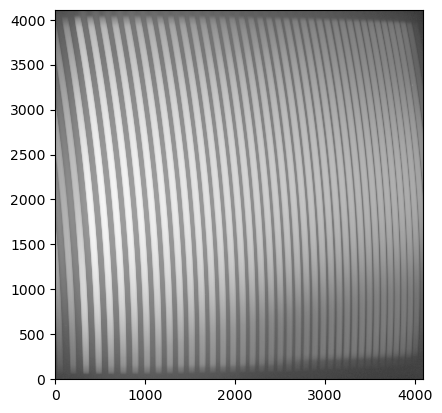

In [17]:
plt.figure()
plt.imshow(image_subtracted_bias, cmap='gray', norm="symlog", origin='lower')
plt.show()

In [60]:
filename = os.path.join('/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Trace', f'veloce_{arm}_4amp_no_sim_calib_trace.pkl')
traces = veloce_reduction_tools.Traces.load_traces(filename)

In [30]:
extracted_science_orders, extracted_order_imgs = veloce_reduction_tools.extract_orders_with_trace(
                            image_subtracted_bias, traces, remove_background=False)

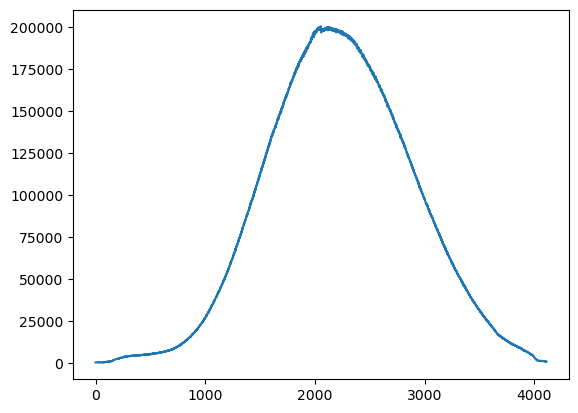

In [33]:
plt.plot(extracted_science_orders[17])

In [30]:
plt.close('all')

### Determine trace shift with ccf

In [ ]:
# from simple_veloce_reduction import veloce_extraction

In [24]:
trace_filename = os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_no_sim_calib_trace.pkl')
traces = veloce_reduction_tools.Traces.load_traces(trace_filename)

In [25]:
trace_filename = os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_no_sim_calib_trace.pkl')
traces_2 = veloce_reduction_tools.Traces.load_traces(trace_filename)

In [31]:
%matplotlib widget

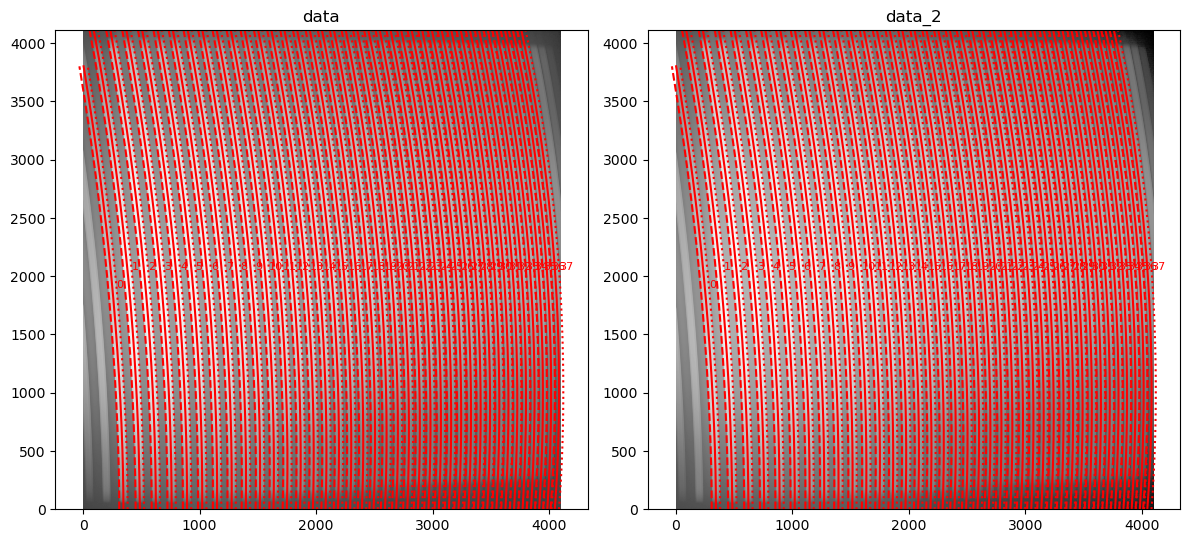

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data, cmap='gray', norm='symlog', origin='lower')
axes[0].set_title('data')
axes[1].imshow(data_2, cmap='gray', norm='symlog', origin='lower')
axes[1].set_title('data_2')
for idx, (trace_y, trace_x, lower, upper) in enumerate(traces):
    axes[0].plot(trace_x, trace_y, c='r')
    axes[1].plot(trace_x, trace_y, c='r')

    axes[0].annotate(str(idx), (trace_x[len(trace_x)//2]+upper, trace_y[len(trace_y)//2]), color='red', fontsize=8)
    axes[0].plot(trace_x+upper,trace_y, ls=':', c='r')
    axes[0].plot(trace_x-lower,trace_y, ls='--', c='r')
    
    axes[1].annotate(str(idx), (trace_x[len(trace_x)//2]+upper, trace_y[len(trace_y)//2]), color='red', fontsize=8)
    axes[1].plot(trace_x+upper,trace_y, ls=':', c='r')
    axes[1].plot(trace_x-lower,trace_y, ls='--', c='r')
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

In [ ]:
# _data_2 = ndimage.zoom(data_2[500:-500, 500:-500], 0.5)
# _data = ndimage.zoom(data[500:-500, 500:-500], 0.5)

In [ ]:
# image_subtracted_bias, hdr = veloce_extraction.remove_scattered_light(image_subtracted_bias, header, traces, False)

In [27]:
# pix_shift, ccf = determine_trace_shift(image_subtracted_bias_2, reference_image=image_subtracted_bias, row=2000)
# pix_shift, ccf = determine_trace_shift(image_subtracted_bias_2, reference_image=image_subtracted_bias)
h_shift, pix_shift, ccf = veloce_reduction_tools.Traces.determine_trace_shift(data_2, reference_frame=data)
print(f'Horizontal shift between two flats: {h_shift} pixels')

Horizontal shift between two flats: -2.0 pixels


In [28]:
traces_2.adjust_traces_with_ccf(data_2, arm)

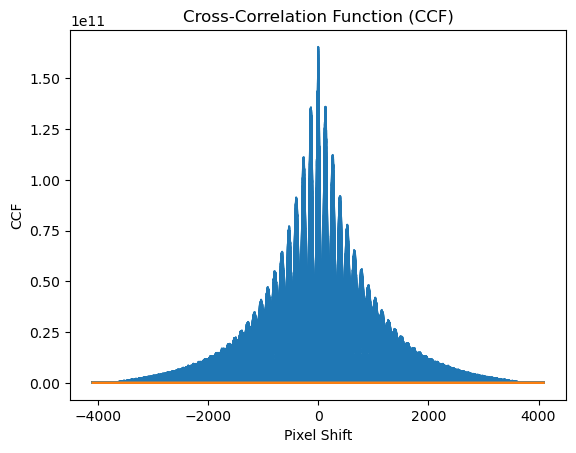

In [29]:
plt.close('all')
for _ccf in ccf:
    plt.plot(pix_shift, _ccf)
plt.xlabel('Pixel Shift')
plt.ylabel('CCF')
plt.title('Cross-Correlation Function (CCF)')
plt.show()

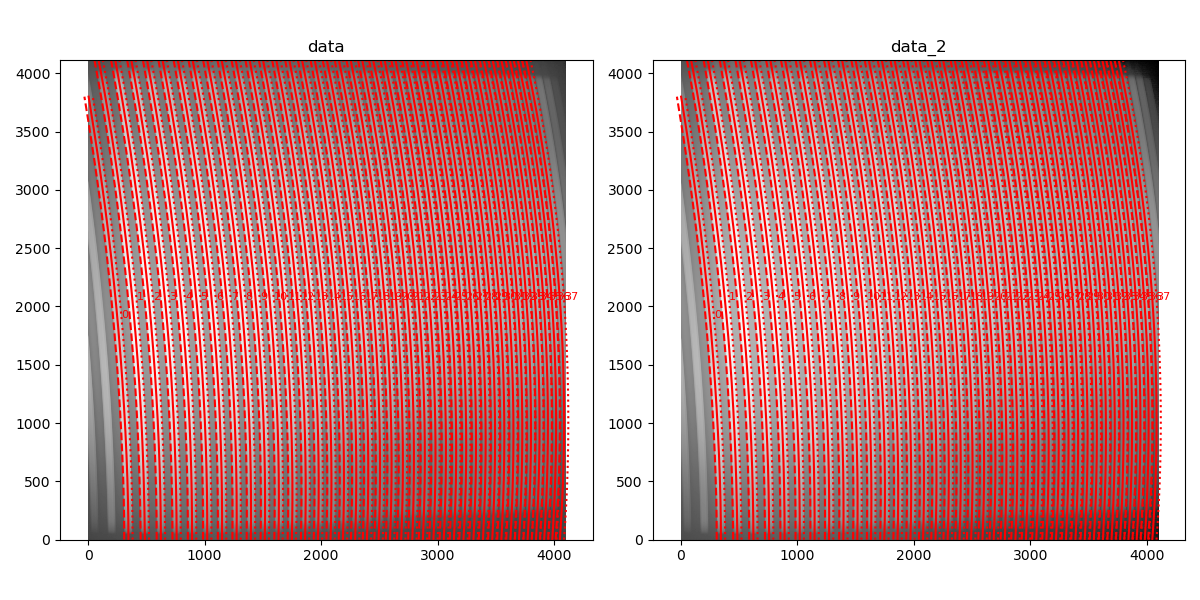

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data, cmap='gray', norm='symlog', origin='lower')
axes[0].set_title('data')
axes[1].imshow(data_2, cmap='gray', norm='symlog', origin='lower')
axes[1].set_title('data_2')
for idx, (trace_y, trace_x, lower, upper) in enumerate(traces):
    axes[0].plot(trace_x, trace_y, c='r')
    axes[0].annotate(str(idx), (trace_x[len(trace_x)//2]+upper, trace_y[len(trace_y)//2]), color='red', fontsize=8)
    axes[0].plot(trace_x+upper,trace_y, ls=':', c='r')
    axes[0].plot(trace_x-lower,trace_y, ls='--', c='r')
for idx, (trace_y, trace_x, lower, upper) in enumerate(traces_2):
    axes[1].plot(trace_x, trace_y, c='r') 
    axes[1].annotate(str(idx), (trace_x[len(trace_x)//2]+upper, trace_y[len(trace_y)//2]), color='red', fontsize=8)
    axes[1].plot(trace_x+upper,trace_y, ls=':', c='r')
    axes[1].plot(trace_x-lower,trace_y, ls='--', c='r')
plt.tight_layout()
plt.show()

In [44]:
%matplotlib inline
# %matplotlib widget

In [28]:
# for i in range(ccf.shape[0]):
#     print(pix_shift[np.argmax(ccf[i])])
# pix_shift[np.argmax(ccf)]

In [49]:
# for i in range(100, 4100, 200):
#     shift, pix_shift, ccf = determine_trace_shift(data_2, reference_image=data, row=i)
#     print(f'Row {i}: shift = {shift}, argmax = {pix_shift[np.argmax(ccf)]}')
#     # print(pix_shift[np.argmax(ccf)])

In [34]:
for i in range(0, 4200, 200):
    print(np.std(data[i,:]), np.mean(data[i,:]), np.max(data[i,:]), np.min(data[i,:]))
    # pix_shift, ccf = determine_trace_shift(data_2, reference_image=data, row=i)
    # print(pix_shift[np.argmax(ccf)])

4.800884 19.293533 30.77738 6.3728595
706.63153 390.5489 2925.7166 10.924902
1656.3153 930.87836 6575.1675 11.83531
2672.0935 1551.2267 10173.323 13.656127
3649.243 2183.6025 14052.206 15.476944
4542.813 2788.075 17549.635 17.297762
5317.3516 3332.0974 20301.879 19.118578
5883.171 3751.7024 22545.83 18.20817
6213.273 4015.0098 23459.826 20.028986
6314.7754 4124.9062 23870.19 21.849804
6132.935 4032.0325 22706.246 21.849804
5747.289 3777.6006 21459.406 22.82649
5201.3325 3406.2495 19135.645 19.973179
4554.859 2963.79 16700.99 20.924282
3892.3738 2508.4001 14555.445 20.924282
3262.0613 2081.7842 12063.366 18.07097
2668.3132 1687.9305 9813.861 15.21766
2130.1143 1337.0137 7947.525 14.266557
1655.3231 1030.4207 6084.158 12.364348
1254.8416 768.46014 4519.802 11.413245
690.02826 433.2498 2734.6536 11.413245


##### Determine summing range

In [33]:
summing_ranges = [(50, 50) for _ in traces.summing_ranges_upper]

In [34]:
traces.set_summing_range(summing_ranges)

In [35]:
extracted_orders, extracted_order_imgs = veloce_reduction_tools.extract_orders_with_trace(
                            data, traces, remove_background=False)

In [36]:
%matplotlib widget

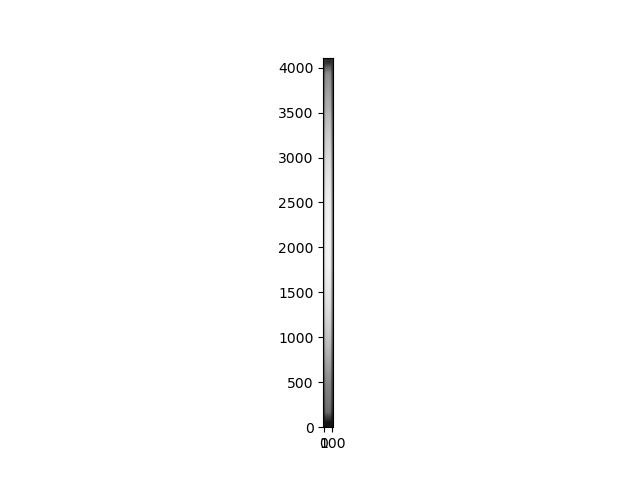

In [37]:
plt.close('all')
plt.imshow(extracted_order_imgs[10], cmap='gray', norm='symlog', origin='lower')
plt.show()

In [54]:
# from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

In [55]:
def find_summing_range(image, traces, search_box=50, plot=False, peak_mode='closest'):
    lower, upper = [], []
    if plot:
        print(f'Plotting trace extraction for order {plot}')
    if plot == True:
        plot = 10
    for idx, (trace_y, trace_x, _, _) in enumerate(traces):
        minima_l = []
        minima_r = []
        for row, x in zip(trace_y, trace_x):
            lower_bound = int(max(0, x - search_box))
            center = int(search_box) if x - search_box >= 0 else int(x)
            upper_bound = int(min(image.shape[1], x + search_box))
            row_data = image[int(row), lower_bound:upper_bound].copy()
            row_data -= np.max(row_data)
            row_data *= -1
            _height = np.median(row_data) + (np.max(row_data) - np.median(row_data))/2
            # _height = np.max(row_data)/2
            peaks, _ = find_peaks(row_data, height=_height, distance=3)
            # peaks = np.where(row_data > _height)[0]

            peaks_l = peaks[peaks < center]
            peaks_r = peaks[peaks > center]

            # Select peak based on peak_mode
            if len(peaks_l) > 0:
                if peak_mode == 'closest':
                    closest_peak = peaks_l[np.argmin(np.abs(peaks_l - center))]
                    minima_l.append(center - closest_peak)
                elif peak_mode == '2nd' and len(peaks_l) > 1:
                    sorted_l = np.argsort(np.abs(peaks_l - center))
                    second_peak = peaks_l[sorted_l[1]]
                    minima_l.append(center - second_peak)
                else:
                    minima_l.append(np.nan)
            else:
                minima_l.append(np.nan)

            if len(peaks_r) > 0:
                if peak_mode == 'closest':
                    closest_peak = peaks_r[np.argmin(np.abs(peaks_r - center))]
                    minima_r.append(closest_peak - center)
                elif peak_mode == '2nd' and len(peaks_r) > 1:
                    sorted_r = np.argsort(np.abs(peaks_r - center))
                    second_peak = peaks_r[sorted_r[1]]
                    minima_r.append(second_peak - center)
                else:
                    minima_r.append(np.nan)
            else:
                minima_r.append(np.nan)

            if idx == plot and row == 2000:
                plt.close('all')
                plt.figure()
                plt.plot(row_data, 'k-')
                plt.plot(peaks, row_data[peaks], "x")
                plt.axvline(center, color='r', linestyle='--', label='Trace Center')
                if minima_l[-1] is not np.nan:
                    plt.axvline(center - minima_l[-1], color='g', linestyle='--', label='Left Minimum')
                if minima_r[-1] is not np.nan:
                    plt.axvline(center + minima_r[-1], color='b', linestyle='--', label='Right Minimum')
                plt.xlabel('Pixel')
                plt.ylabel('Counts')
                plt.title(f'Row {row}, Order {idx}')
                plt.legend()
                plt.show()
        lower.append(int(np.nanmedian(minima_l))+1)
        upper.append(int(np.nanmedian(minima_r))+1)
    if len(lower) != len(traces):
        print(f'Warning: found {len(lower)} summing ranges, but {len(traces)} traces')
    return np.array(lower), np.array(upper)
        

In [39]:
from simple_veloce_reduction import veloce_extraction

In [104]:
data_bkg, hdr = veloce_extraction.remove_scattered_light(data, header, traces, diagnostic=False)

Plotting trace extraction for order 9


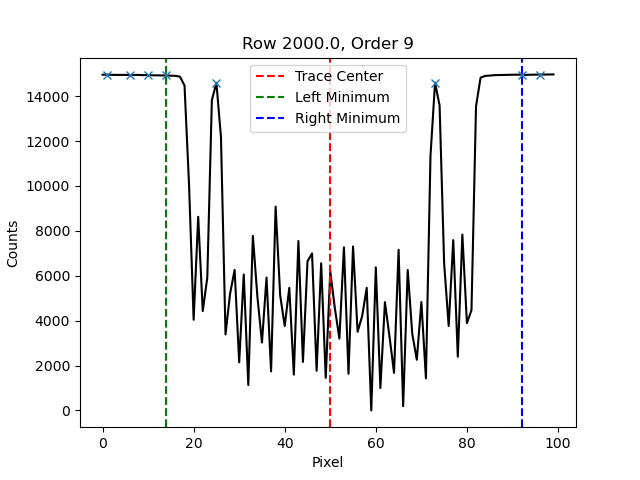

In [ ]:
# _lower, _upper = find_summing_range(data, traces, search_box=50, plot=30, peak_mode='closest')
_lower, _upper = veloce_reduction_tools.Traces.determine_summing_range(data, traces, search_box=50, plot=9, peak_mode='2nd')

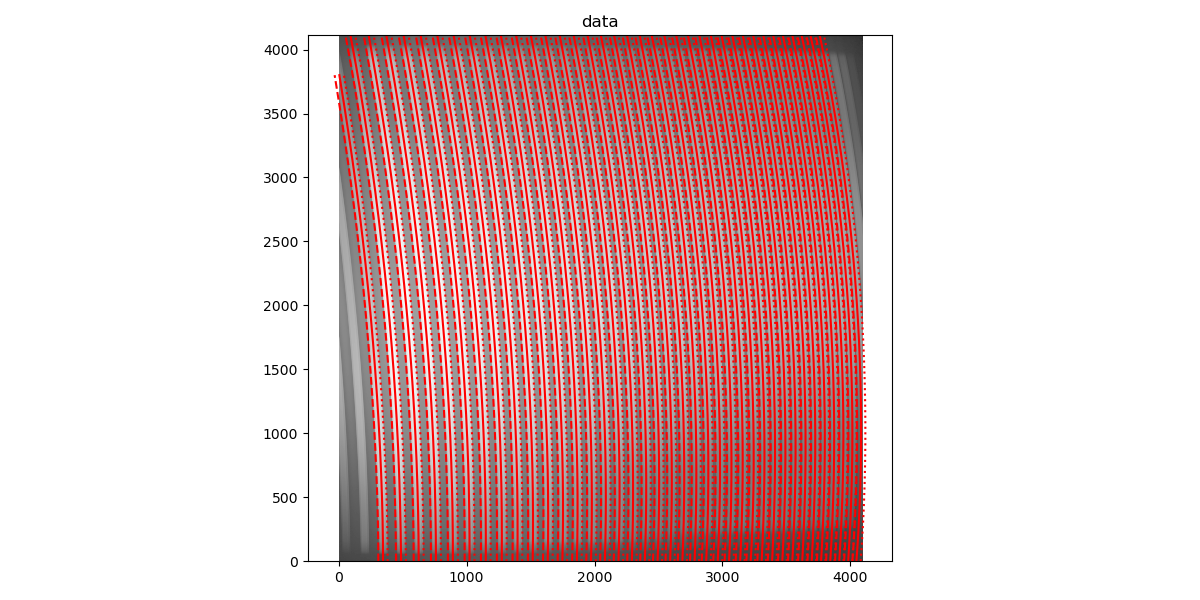

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
# axes.imshow(data, cmap='gray', norm='symlog', origin='lower')
axes.imshow(data, cmap='gray', norm='symlog', origin='lower')
axes.set_title('data')
for (trace_y, trace_x, _, _), lower, upper in zip(traces, _lower, _upper):
    axes.plot(trace_x, trace_y, c='r')
    # axes[0].annotate(str(idx), (trace_x[len(trace_x)//2]+upper, trace_y[len(trace_y)//2]), color='red', fontsize=8)
    axes.plot(trace_x+upper,trace_y, ls=':', c='r')
    axes.plot(trace_x-lower,trace_y, ls='--', c='r')
plt.tight_layout()
plt.show()

In [58]:
# for lower, upper in zip(_lower, _upper):
#     print(lower, upper, lower+upper)

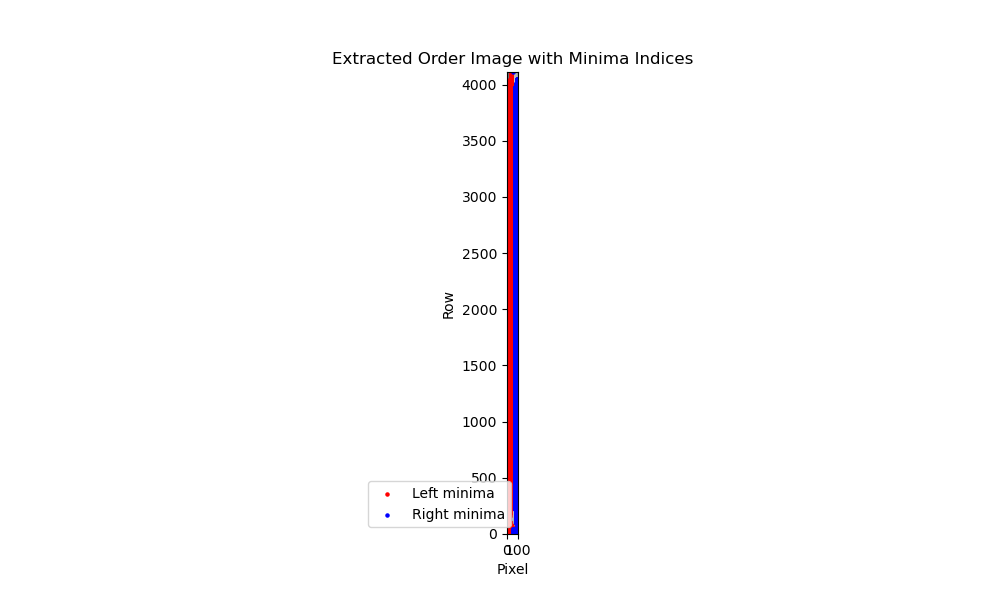

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.imshow(extracted_order_imgs[10], cmap='gray', norm='symlog', origin='lower')
# plt.scatter(minima_indices_l, np.arange(len(minima_indices_l)), color='red', s=5, label='Left minima')
# plt.scatter(minima_indices_r, np.arange(len(minima_indices_r)), color='blue', s=5, label='Right minima')
# plt.xlabel('Pixel')
# plt.ylabel('Row')
# plt.legend()
# plt.title('Extracted Order Image with Minima Indices')
# plt.show()

### 2a. Load prefitted traces for calib fibers

Load prefitted trace to refit or skip to determining orders from flux in flat images

In [11]:
order_nums, coeffs, traces = veloce_reduction_tools.load_prefitted_wavecalib_trace(arm=arm, calib_type='Th')

In [16]:
input_dir = os.path.join(data_path, run)
output_dir = os.path.join('/home/usqobserver2/Joachim_veloce/Veloce_reduction/Trace/')
veloce_paths = veloce_config.VelocePaths(input_dir, output_dir, run=run)
# veloce_paths.__post_init__()

 does not match run name: Delta_Call_2025_accretion
Creating output subdirectory with run name.


In [17]:
trace_path = veloce_paths.trace_dir
if not os.path.exists(trace_path):
    print(f"{trace_path} does not exist")
trace_filename = f'veloce_{arm}_4amp_sim_calib_trace.pkl'
traces = veloce_reduction_tools.Traces.load_traces(os.path.join(trace_path, trace_filename))
# trace_filename = f'veloce_{arm}_4amp_sim_calib_trace.pkl'
new_traces = veloce_reduction_tools.Traces.load_traces(os.path.join(trace_path, trace_filename))


In [13]:
# old format for saved traces
# trace_data = np.load('./Trace/veloce_green_4amp_no_sim_calib_trace.npz')
# traces, summing_ranges = trace_data['traces'], trace_data['summing_ranges']

In [25]:
%matplotlib widget

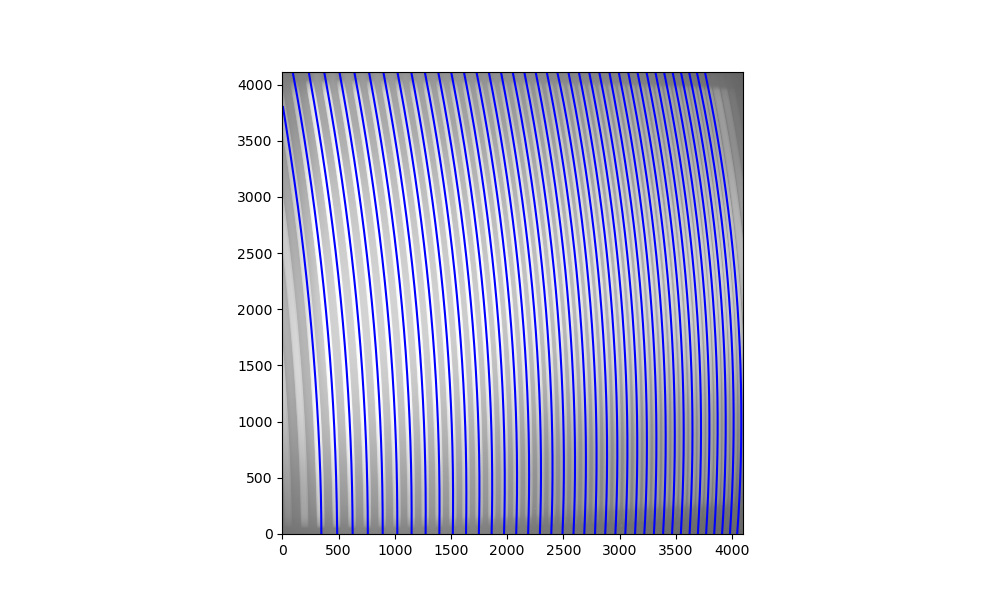

In [26]:
plt.figure(figsize=(10, 6))
plt.imshow(image_subtracted_bias, cmap='gray', norm="symlog", origin='lower')
for trace_y, trace_x in zip(traces.y, traces.x):
    plt.plot(trace_x, trace_y, 'b')
plt.show()

In [27]:
plt.close()

In [28]:
# Delete and collect garbage
del image_data
gc.collect()

9415

In [29]:
''' 
shape is consistent with info from manual 
but there is a row of 'bias' pixels at the top of the image (row 4111)
'''
image_subtracted_bias.shape

(4112, 4096)

### 2b. Detect flux through thresholding to get initial trace for each order

skip when refitting existing trace

In [81]:
# blured = median_filter(image_subtracted_bias, (5,15)) #blue
blured = median_filter(image_subtracted_bias, (1,21)) #green
# blured = median_filter(image_subtracted_bias, (10,10)) #red
# blured = median_filter(image_subtracted_bias, (5,5))

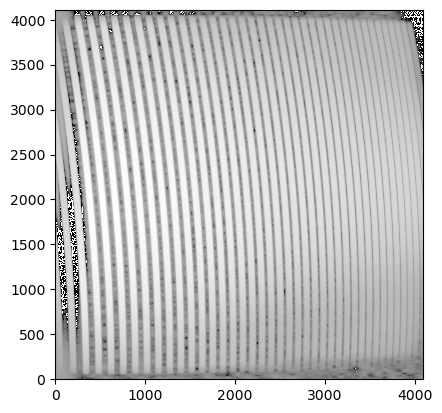

In [82]:
plt.figure()
plt.imshow(blured, cmap='gray', norm='log', origin='lower')
plt.show()
# blured = image_substracted_bias

In [83]:
plt.close()

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Cross-section at row 2000'}, xlabel='Pixel', ylabel='Counts'>)

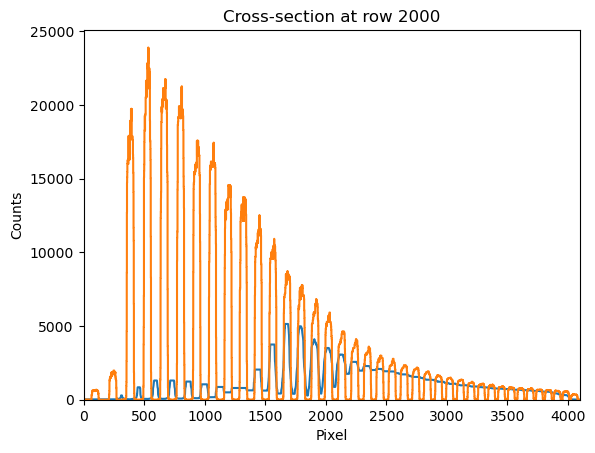

In [84]:
n = 2000
# veloce_reduction_tools.plot_cross_section(image_substracted_bias, n, axis='x')
veloce_reduction_tools.plot_cross_section(blured, n, axis='x')

In [85]:
plt.close('all')


Result: pixels belonging to orders, this is done on flats.

Threshold detected per row, as median filter with wide span

In [86]:
binarized = veloce_reduction_tools.get_binary_mask(blured, arm=arm, axis='x')

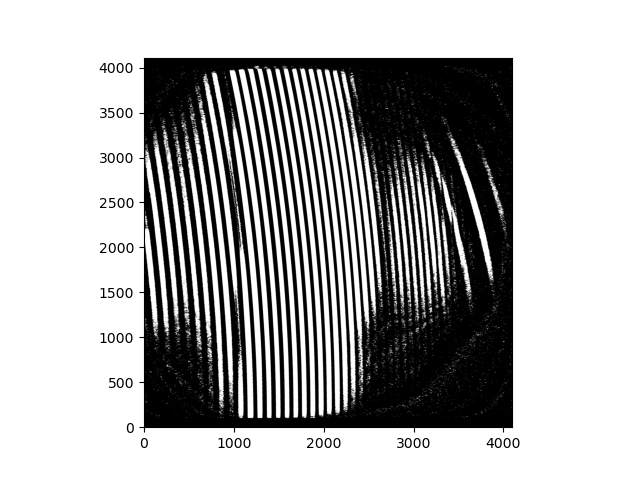

In [78]:
plt.figure()
plt.imshow(binarized, cmap='gray', origin='lower')
plt.show()

In [87]:
plt.close()

In [88]:
del blured
gc.collect()

466

In [27]:
orders = veloce_reduction_tools.get_orders_masks(binarized)

In [28]:
del binarized
gc.collect()

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


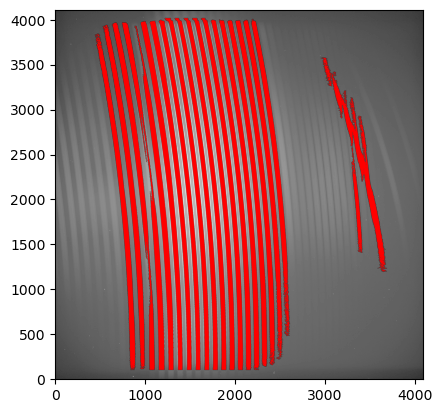

In [29]:
img_orders = merge_masks_with_alpha(orders)
plt.figure()
plt.imshow(image_subtracted_bias, cmap='gray', norm='log', origin='lower')
plt.imshow(img_orders, origin='lower')
plt.show()

In [27]:
plt.close('all')

del img_orders
gc.collect()

3285

In [ ]:
len(orders)

39

### 3. Get and smooth the trace or adjust existing one

average in x direction, and fit the polynomial

In [21]:
# traces = veloce_reduction_tools.get_traces(image_subtracted_bias, orders)

In [30]:
# del orders
# gc.collect()

Adjust existing traces by shifting in cross dispersion direction (x) to align with mid position determined by weighted average around initial trace.

In [65]:
# new_traces = veloce_reduction_tools.Traces([(y, x-21) for y, x in traces])

In [19]:
# fit_width = 35 # green
# fit_width = 25 # red
fit_width = 40 # blue
# fit_width = np.max(np.array([traces.summing_ranges_lower, traces.summing_ranges_upper]))

In [20]:
# traces = veloce_reduction_tools.refit_traces(image_subtracted_bias, x, y, fit_width=20)
# traces = veloce_reduction_tools.adjust_traces(image_subtracted_bias, x, y)
# new_traces.adjust_traces(image_subtracted_bias, fit_width=fit_width, tolerance=1e-5)
new_traces.adjust_traces(blured, fit_width=fit_width, tolerance=1e-5)

In [21]:
# load wave calibration based on ThAr
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(arm=arm, wave_path=veloce_paths.wave_dir)
    

In [22]:
print(len(new_traces), len(COEFFS))

29 29


In [37]:
for order_trace, order_wave in zip(order_nums, ORDER):
    print(order_trace, order_wave)

NameError: name 'order_nums' is not defined

In [66]:
# new_traces.set_traces(new_traces.traces[1:])

In [26]:
# traces = veloce_reduction_tools.Traces(traces=new_traces, summing_ranges=summing_ranges, wavelength_slice=slice(None))

In [19]:
plt.close('all')

### 4. Work out summing range

I wanted to work out a criteria for that but in the end it was more practical to check flat, science and calibration (simultanious Th and LC) data to place borders for data extraction.

The Flat data has light in the sky fibers so the trace is ofset to the side with 3 sky fibers, this is fixed by assymetric summing range.

In [40]:
%matplotlib inline

In [24]:
%matplotlib widget

First no sim calib.

In [71]:
summing_ranges = [(35,35) for _ in range(len(new_traces.traces))]
new_traces.set_summing_range(summing_ranges)

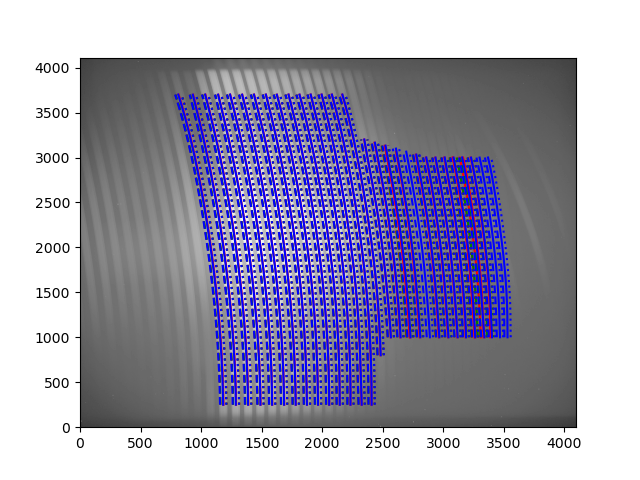

In [25]:
j = None

plt.figure()
plt.imshow(image_subtracted_bias, cmap='gray', norm="log", origin='lower', aspect='auto')
# plt.imshow(blured, cmap='gray', norm="log", origin='lower', aspect='auto')

if j is None:
    for trace_y, trace_x, lower_range, upper_range in new_traces:
        plt.plot(trace_x, trace_y, 'r')
        plt.plot(trace_x-lower_range, trace_y, 'r--')
        plt.plot(trace_x+upper_range, trace_y, 'r:')
        
        plt.plot(trace_x-25, trace_y, 'g--')
        plt.plot(trace_x+25, trace_y, 'g:')
    for trace_y, trace_x, lower_range, upper_range in traces:
        plt.plot(trace_x, trace_y, 'b')
        plt.plot(trace_x-lower_range, trace_y, 'b--')
        plt.plot(trace_x+upper_range, trace_y, 'b:')
elif j!=1:
    for trace_y, trace_x, lower_range, upper_range in zip(new_traces.y[-1*j:-1*j+1], new_traces.x[-1*j:-1*j+1], new_traces.summing_ranges_lower[-1*j:-1*j+1], new_traces.summing_ranges_upper[-1*j:-1*j+1]):
        plt.plot(trace_x, trace_y, 'r')
        plt.plot(trace_x-lower_range, trace_y, 'r--')
        plt.plot(trace_x+upper_range, trace_y, 'r:')
    for trace_y, trace_x, lower_range, upper_range in traces[-1*j:-1*j+1]:
        plt.plot(trace_x, trace_y, 'b')
        plt.plot(trace_x-lower_range, trace_y, 'b--')
        plt.plot(trace_x+upper_range, trace_y, 'b:')
else:
    for trace_y, trace_x, lower_range, upper_range in zip(new_traces.y[-1:], new_traces.x[-1:], new_traces.summing_ranges_lower[-1:], new_traces.summing_ranges_upper[-1:]):
        plt.plot(trace_x, trace_y, 'r')
        plt.plot(trace_x-lower_range, trace_y, 'r--')
        plt.plot(trace_x+upper_range, trace_y, 'r:')
    for trace_y, trace_x, lower_range, upper_range in traces[-1:]:
        plt.plot(trace_x, trace_y, 'b')
        plt.plot(trace_x-lower_range, trace_y, 'b--')
        plt.plot(trace_x+upper_range, trace_y, 'b:')

ylen, xlen = image_subtracted_bias.shape
# plt.xlim(0, xlen)
# plt.xlim(3420, 3530)
# plt.ylim(0, ylen)
# plt.ylim(2030, 2480)

plt.show()

In [ ]:
# order = 0

# plt.figure()
# plt.imshow(image_subtracted_bias, cmap='gray', norm="symlog", origin='lower', aspect='auto')

# plt.plot(new_traces.x[order], new_traces.y[order], 'r')
# plt.plot(new_traces.x[order]-new_traces.summing_ranges_lower[order], trace_y, 'r--')
# plt.plot(new_traces.x[order]+new_traces.summing_ranges_upper, new_traces.y[order], 'r:')

# ylen, xlen = image_subtracted_bias.shape
# plt.xlim(0, xlen)
# plt.ylim(0, ylen)

# plt.show()

In [54]:
plt.close('all')

In [46]:
len(new_traces)

40

In [ ]:
# new_traces.set_traces(new_traces.traces[0:-1])
# new_traces.set_summing_range(summing_ranges[0:-1])
# new_traces.wave_calib_slice = slice(None, -1)

In [ ]:
filename = f'veloce_{arm}_{amplifier_mode}amp_sim_calib_trace_{header["DATE-OBS"]}'
# filename = f'veloce_{arm}_{amplifier_mode}amp_no_sim_calib_trace'
new_traces.save_traces(arm=arm, amplifier_mode=amplifier_mode, sim_calib=True, filename=filename, trace_dir=trace_path)

And now for the case with sim calib

In [ ]:
### science data with LC
# data_path = '/home/usqobserver2/VeloceData'
# run = 'CSV_Run'
# date = '230826'
# ccd = 'ccd_3'
det_num = ccd.split('_')[1]
# filename = f'26aug{det_num}0148.fits'
filename = f'04apr{det_num}0082.fits'
spectrum_filename =  os.path.join(data_path, run, date, ccd, filename)

In [ ]:
### SimTh 
# data_path = '/home/usqobserver2/VeloceData'
# run = 'CSV_Run'
# date = '230826'
# ccd = 'ccd_2'
# filename = f'26aug20074.fits'
# spectrum_filename =  os.path.join(data_path, run, date, ccd, filename)

In [ ]:
with fits.open(spectrum_filename) as hdul:
    image_data = hdul[0].data
    header = hdul[0].header
image_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, hdr=header, arm=arm, amplifier_mode=amplifier_mode, overscan_range=32)

Gain for half 1: 1.01
Gain for half 2: 0.97364


In [40]:
del image_data, header
gc.collect()

1748

In [41]:
%matplotlib inline

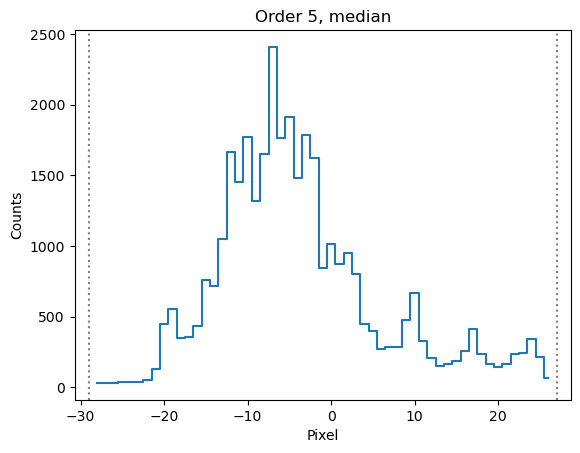

In [42]:
plt.figure()
order_img = veloce_reduction_tools.plot_order_cross_section(image_subtracted_bias, new_traces, 5, margin=[0,0])
plt.show()

In [121]:
plt.close()

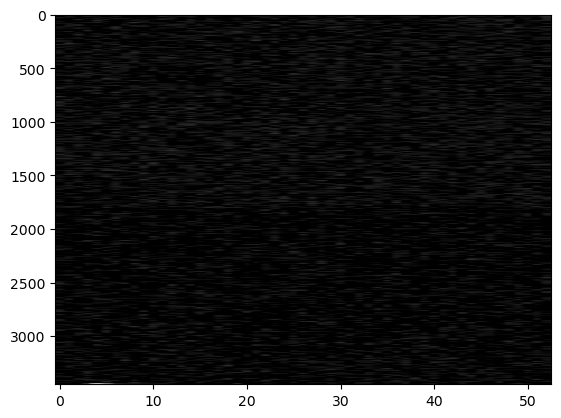

In [122]:
plt.figure()
plt.imshow(order_img, cmap='gray', norm='log', aspect='auto')
plt.show()

In [84]:
# plt.close()

In [112]:
del order_img
gc.collect()

3064

For red from CSV Run: (25,23) <br>
For green from CSV Run: (28,26) - sim calib, (36,36) - no calib <br>
For blue from CSV Run: () <br>

For green from Xmas run: () <br>
For red from Xmas Run: () <br>
For Blue from Xmas Run: () <br>

For green 2 amp mode: () <br>
For red 2 amp mode: () <br>
For blue 2 ampl mode: () <br>

In [26]:
%matplotlib widget

In [86]:
summing_ranges = [(26,26) for _ in range(len(new_traces.traces))]
new_traces.set_summing_range(summing_ranges)

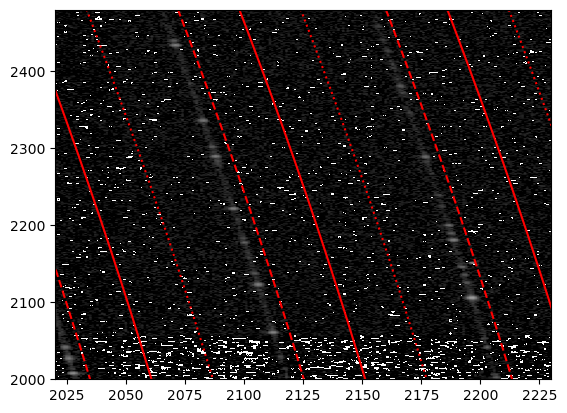

In [114]:
plt.figure()
plt.imshow(image_subtracted_bias, cmap='gray', norm="log", origin='lower', aspect='auto')

for trace_y, trace_x, lower_range, upper_range in new_traces:
    plt.plot(trace_x, trace_y, 'r')
    plt.plot(trace_x-lower_range, trace_y, 'r--')
    plt.plot(trace_x+upper_range, trace_y, 'r:')

ylen, xlen = image_subtracted_bias.shape
# plt.xlim(0, xlen)
plt.xlim(2020, 2230)
# plt.ylim(0, ylen)
plt.ylim(2000, 2480)

plt.show()

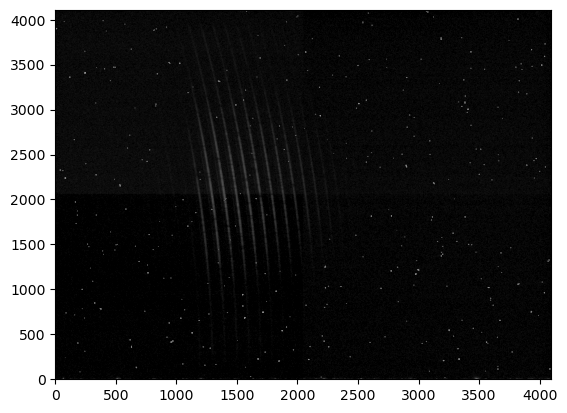

In [105]:
plt.figure()
plt.imshow(image_subtracted_bias, cmap='gray', norm="log", origin='lower', aspect='auto')
plt.show()

In [50]:
plt.close('all')

In [ ]:
new_traces.save_traces(arm=arm, amplifier_mode=amplifier_mode, sim_calib=True)

### 5. Save traces

In [ ]:
### green from CSV Run - after inspection edge orders are incomplete and not usable
# traces=traces[1:-1]
# summing_ranges=summing_ranges[1:-1]

# np.savez('./Trace/veloce_green_4amp_trace', traces=traces, summing_ranges=summing_ranges)

In [59]:
### red from CSV Run - after inspection first order (104) is incomplete and wasn't identified removing it from - loading data  
# traces=traces[1:-1]
# summing_ranges=summing_ranges[1:-1]

np.savez('./Trace/veloce_green_4amp_no_sim_calib_trace', traces=traces, summing_ranges=summing_ranges)

In [ ]:
# save_traces(traces=adjusted_traces, summing_ranges=summing_ranges, wave_calib_slice=slice(None), filename='veloce_green_fromTh_4amp_no_sim_calib_trace')
# new_traces.save_traces(filename='veloce_green_4amp_no_sim_calib_trace')
# new_traces.save_traces(arm=arm, amplifier_mode=amplifier_mode, sim_calib=False)

In [ ]:
# def get_file_type(filename):
#     if filename.endswith('.fits'):
#         with fits.open(filename) as hdul:
#             header = hdul[0].header
        

In [ ]:
# def scan_input_dir(veloce_paths, config):
#     """
#     Scans the input directory for files and returns a list of files.

#     Parameters:
#     - veloce_paths (VelocePaths): An instance of the VelocePaths class containing the input directory path.

#     Returns:
#     - list: A list of files in the input directory.
#     """
#     files = os.listdir(veloce_paths.input_dir)

#     obs_list = {'flat_red': [], 'flat_green': [], 'flat_blue': [], 'flat_blue_long': [],
#             'ARC-ThAr': [], 'SimThLong': [], 'SimTh': [], 'SimLC': [],
#             'dark': [], 'bias': [], 'science': []}

#     arms = {'red': 3, 'green': 2, 'blue': 1, 'all': None}
#     with open(log_path, 'r') as f:
#         lines = f.readlines()
#         for line in lines[10:]:
#             if line[0:4].isdigit():
#                 run, arm, target, exp_time = [line.split()[i] for i in [0, 1, 2, 5]]
#                 file_name = f'{day}{arm}{run}.fits'
#                 if int(arm) == arms[selected_arm] or selected_arm == 'all':
#                     if target.strip() == 'BiasFrame':
#                         obs_list['bias'].append(file_name)
#                     elif target.strip() == 'FlatField-Quartz':
#                         if float(exp_time) == 0.1:
#                             obs_list['flat_red'].append(file_name)
#                         elif float(exp_time) == 1.0:
#                             obs_list['flat_green'].append(file_name)
#                         elif float(exp_time) == 10.0:
#                             obs_list['flat_blue'].append(file_name)
#                         elif float(exp_time) == 60.0:
#                             obs_list['flat_blue_long'].append(file_name)
#                         else:
#                             pass
#                             # print(f"[Warning]: Non standard flat exp time = {exp_time} for {file_name}")
#                     elif target.strip() == 'ARC-ThAr':
#                         obs_list['ARC-ThAr'].append(file_name)
#                     elif target.strip() == 'SimThLong':
#                         obs_list['SimThLong'].append(file_name)
#                     elif target.strip() == 'SimTh':
#                         obs_list['SimTh'].append(file_name)
#                     elif target.strip() == 'SimLC':
#                         obs_list['SimLC'].append(file_name)
#                     elif target.strip() == 'DarkFrame':
#                         obs_list['dark'].append(file_name)
#                     elif target.strip() in science_targets or science_targets is None:
#                         obs_list['science'].append([target.strip(), file_name])
#                     else:
#                         pass
                    
#     return obs_list